In [ ]:
import hypernetx as hnx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import warnings 
warnings.simplefilter('ignore')



hello


The `hypernetx` library can construct hypergraphs from many python data structures (lists, dictionaries, etc.)

Here I focus on what should matter in the mathematical approach, i.e. the **incidence matrices**.

I'll think of Gatien's [2025 work](https://journals.aps.org/pre/abstract/10.1103/4rsy-786t) paper and try to implement a piece of the circuit in Fig 1.


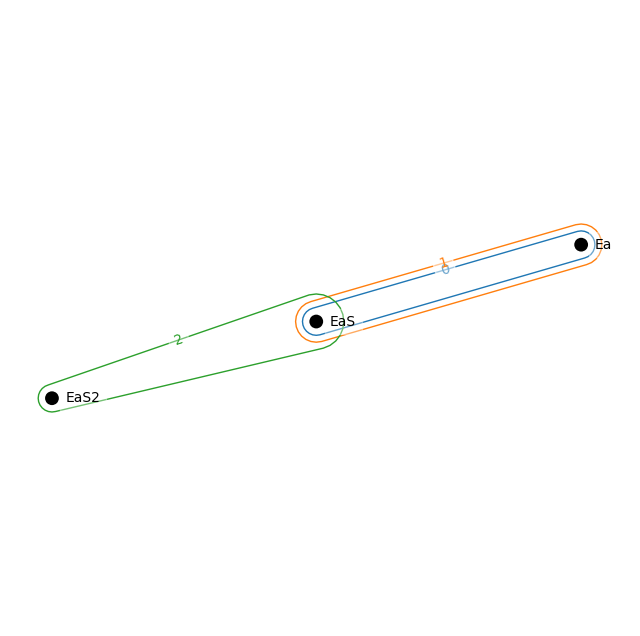

In [9]:
# incidence matrix for the inner part of the top circuit
# the rows are the verrtices and the columns are the hyperdges
# if an element ij is nonzero, then the vertex i is in the hyperdge j

#  here the row
# 0 -> Ea
# 1 -> EaS
# 2 -> EaS2
#  
# while the column
# 0 -> reaction 1
# 1 -> reaction 2
# 2 -> reaction3


inner_1 = np.array([
    [-1,1,0],
    [1,-1,-1],
    [0,0,1]

])
node_labels = {0:'Ea', 1:'EaS', 2:'EaS2'}
H = hnx.Hypergraph.from_incidence_matrix(inner_1)

hnx.draw(H, node_labels = node_labels)

# print(H.dataframe)

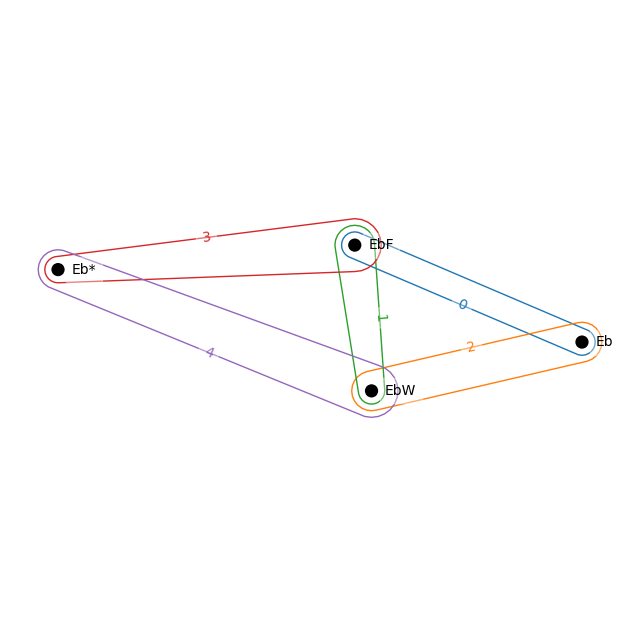

In [19]:
inner_2 = np.array([
[-1,0,1,0,0],
[1,-1,0,-1,0],
[0,1,-1,0,1],
[0,0,0,1,-1]
])
node_labels = {0:'Eb', 1:'EbF', 2:'EbW', 3:'Eb*'}
H = hnx.Hypergraph.from_incidence_matrix(inner_2)

hnx.draw(H, node_labels = node_labels )


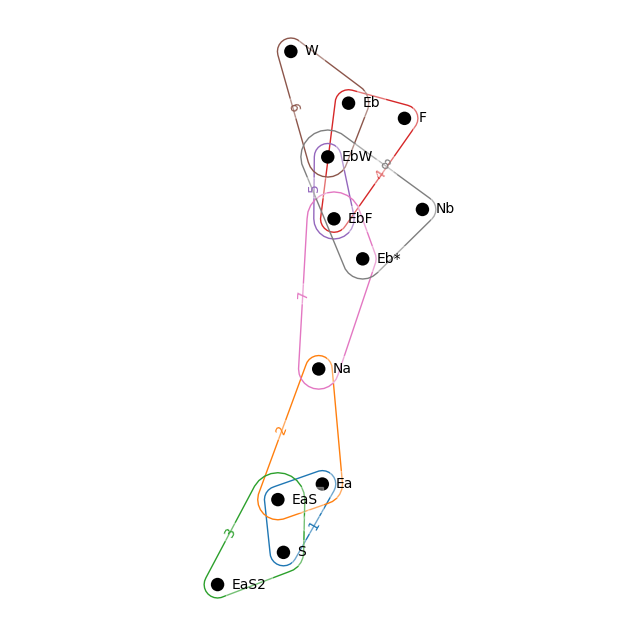

In [15]:
# full network
import matplotlib.pyplot as plt
# rows are nots, columns are edges (reactions)
graph = {
            1:["S","Ea", "EaS"],
          2:["Ea", "EaS", "Na"],
          3:["EaS","S", "EaS2"],
          4:["F", "Eb","EbF"],
          5:["EbF","EbW"],
          6:["EbW", "Eb","W"],
          7:["EbF", "Na","Eb*"],
          8:["Eb*", "EbW", "Nb"]
          
          }

# print(H.dataframe)
H = hnx.Hypergraph(graph)
hnx.draw(H)
plt.savefig("graph.pdf")

It seem that for the **stoichiometric matrices** Gatien essentially uses a matrix with some labellling to keep track of what the roows are, distinguishing the upper and the lower block for the interal and external species:

- the internal above the line
- the external below the line

Therefore I construct a custom class to encode that:

In [ ]:
import numpy as np
import sympy

class LabelledStoichiometricMatrix:
    def __init__(self,matrix, last_internal):
        """Construct a labelled stoichiometric matrix from a complete matrix where we keep track of internal and external species.
        
        Args:
            matrix (np.ndarray): The complete matrix
            last_internal (int): The index (0-based) of the last internal species (below which all the rows are external)"""
        self.complete = matrix
        self.last_internal = last_internal
        self.internal = matrix[:last_internal+1]
        self.external = matrix[last_internal+1:]
    def __repr__(self):
        
        # Determine column width based on the longest number in any row
        col_width = max(len(str(x)) for row in self.complete for x in row) + 1
        
        repr_str = ""
        for i, row in enumerate(self.complete):
            # Format each row with right-aligned numbers
            string_row = " ".join(f"{x:>{col_width}}" for x in row)
            
            # Insert horizontal line after `last_internal+1` row
            if i == self.last_internal + 1:
                repr_str += "-" * (len(string_row)) + "\n"
            
            repr_str += string_row + "\n"
        
        return repr_str
    


## Implementing the example for good


### Stoichiometric matrices

We start by defining the two **stoichiometric** matrices of Gatien's example. 

In [13]:
nabla_1 = LabelledStoichiometricMatrix(

    np.array([
        [-1,1,0],
        [1,-1,-1],
        [0,0,1],
        [-1,0,-1],
        [0,2,0],]),
        2
)
nabla_1

NameError: name 'LabelledStoichiometricMatrix' is not defined

In [ ]:
nabla_2 = LabelledStoichiometricMatrix(

    np.array([
        [-1,0,1,0,0],
        [1,-1,0,-1,0],
        [0,1,-1,0,1],
        [0,0,0,1,-1],
        [0,0,0,-1,0],
        [0,0,0,0,1],
        [-1,0,0,0,0],
        [0,0,1,0,0],
        ]),
        3
)
nabla_2

 -1   0   1   0   0
  1  -1   0  -1   0
  0   1  -1   0   1
  0   0   0   1  -1
-------------------
  0   0   0  -1   0
  0   0   0   0   1
 -1   0   0   0   0
  0   0   1   0   0

### Currents

I try to do this symbolically to check.



In [ ]:
import sympy

j1, j2, j3, j4, j5, j6, j7, j8 = sympy.symbols("j1 j2 j3 j4 j5 j6 j7 j8")


_j1 = sympy.Matrix([[j1],[j2],[j3]])

_j2 = sympy.Matrix([[j4],[j5],[j6],[j7],[j8]])

_j2

Matrix([
[j4],
[j5],
[j6],
[j7],
[j8]])

### Cycles

In [ ]:
from scipy.linalg import null_space
from scipy.linalg import lu


In [ ]:
C_inner_1 = sympy.Matrix(nabla_1.internal).nullspace()[0]
C_inner_1


Matrix([
[1],
[1],
[0]])

In [ ]:
_C_inner_2 = sympy.Matrix(nabla_2.internal).nullspace()
# rearrange 
C_inner_2 = sympy.Matrix([_C_inner_2])

C_inner_2

Matrix([
[1,  0],
[1, -1],
[1,  0],
[0,  1],
[0,  1]])

This is different from Gatien's but they should be equivalent (TEST this). A way to test this is to find an inveritble matrix P that transforms this into the other so that 

$$C_{\rm scipy} P = C_{\r Gatien}$$

I assume that this works and go ahead with the code.

So I can start by testing that 

$$\boldsymbol{\nabla}_{\mathrm{internal}} \boldsymbol{j}=\mathbf{0}$$



In [20]:
constraint_1 = sympy.solve (nabla_1.internal*_j1, _j1)
constraint_1

NameError: name 'sympy' is not defined

In [ ]:
constraint_2 = sympy.solve(nabla_2.internal*_j2, _j2)

constraint_2

{j4: j6, j5: j6 - j8, j7: j8}

Which all together are equations (54,55) of Gatien's paper.



Eq. 82,83 can be understood only if we take the **constraints** above and we implement them [CHECK THAT THIS IS TRUE USING SYMPY AND THE SOLUTIONS ABOVE]




In [ ]:
(C_inner_1.T*_j1).subs(constraint_1)

Matrix([[2*j2]])

In [ ]:
(C_inner_2.T*_j2).subs(constraint_2)

Matrix([
[ 3*j6 - j8],
[-j6 + 3*j8]])

The same for 83-84

In [ ]:
(-nabla_1.external*_j1).subs(constraint_1)

Matrix([
[ j2],
[-j2]])

In [ ]:
(-nabla_2.external*_j2).subs(constraint_2)

Matrix([
[ j8],
[-j8],
[ j6],
[-j6]])

### Conservation laws

It is not very clear to me how you draw the horizontal/vertical lines to identify the various bits of the conservation laws

- the vertical line should simply be the interval vs external species
- the horizontal line seems to be just after the first row, but it is not clear why. There must be a simple way to figure this out automatically.

In [ ]:
ell1 =sympy.Matrix([sympy.Matrix(nabla_1.complete).T.nullspace()]).T

ell1


Matrix([
[ 1,  1, 1, 0, 0],
[-2, -1, 0, 1, 1]])

In [ ]:
ell2 =sympy.Matrix([sympy.Matrix(nabla_2.complete).T.nullspace()]).T

ell2


Matrix([
[ 1,  1,  1, 1, 0, 0, 0, 0],
[-1, -1, -1, 0, 1, 1, 0, 0],
[-1,  0,  0, 0, 0, 0, 1, 1]])